# Exercise 1

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
import warnings

warnings.filterwarnings("ignore")

# Load datasets
mnist = fetch_openml('mnist_784', version=1)
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)

clustering_algos = {
    "kmeans": KMeans,
    "dbscan": DBSCAN,
    "agglomerative": AgglomerativeClustering
}

reduction_methods = [None, "PCA", "UMAP"]


def reduce_dimensionality(data, method):
    if method == "PCA":
        return PCA(n_components=2, random_state=42).fit_transform(data)
    elif method == "UMAP":
        return umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42).fit_transform(data)
    else:
        return data


def run_dataset(data):
    for r in reduction_methods:
        data_red = reduce_dimensionality(data, r)
        for k, v in clustering_algos.items():
            model = v()
            if k == "dbscan":
                model = DBSCAN(eps=3, min_samples=10)
                labels = model.fit(data_red)
            else:
                labels = model.fit_predict(data_red)

            if len(np.unique(labels)) > 1:
                silhouette = silhouette_score(data_red, labels)
                print("")
                print(f"Silhouette-Score für {k} mit {r}-Reduktion: {silhouette:.4f}")
            else:
                print(f"{k} mit {r}-Reduktion: Nur ein Cluster gefunden; Silhouette-Score nicht berechenbar.")


run_dataset(mnist.data[:10000])


Silhouette-Score für kmeans mit None-Reduktion: 0.0503
dbscan mit None-Reduktion: Nur ein Cluster gefunden; Silhouette-Score nicht berechenbar.

Silhouette-Score für agglomerative mit None-Reduktion: 0.1166

Silhouette-Score für kmeans mit PCA-Reduktion: 0.3623
dbscan mit PCA-Reduktion: Nur ein Cluster gefunden; Silhouette-Score nicht berechenbar.

Silhouette-Score für agglomerative mit PCA-Reduktion: 0.3586

Silhouette-Score für kmeans mit UMAP-Reduktion: 0.4617
dbscan mit UMAP-Reduktion: Nur ein Cluster gefunden; Silhouette-Score nicht berechenbar.

Silhouette-Score für agglomerative mit UMAP-Reduktion: 0.4129


# Niklas

# Exercise 2a

In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, jaccard_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import umap
import warnings

warnings.filterwarnings("ignore")

# Load datasets
mnist = fetch_openml('mnist_784', version=1)
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)

# Clustering algorithms
clustering_algos = {
    "KMeans": KMeans,
    "DBSCAN": DBSCAN,
    "Agglomerative": AgglomerativeClustering
}

# Dimensionality reduction methods
reduction_methods = [None, "PCA", "UMAP"]


def reduce_dimensionality(data, method):
    """Reduce dimensionality using the specified method."""
    if method == "PCA":
        return PCA(n_components=2, random_state=42).fit_transform(data)
    elif method == "UMAP":
        return umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42).fit_transform(data)
    else:
        return data


def find_optimal_dbscan_params(data):
    """Find optimal parameters for DBSCAN using a heuristic approach."""
    from sklearn.neighbors import NearestNeighbors

    # Compute distances to nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=5).fit(data)
    distances, _ = nbrs.kneighbors(data)
    distances = np.sort(distances[:, 4])  # 4th neighbor (min_samples - 1)

    # Use the "elbow" method to find a good eps
    eps = np.percentile(distances, 95)  # Use the 95th percentile as a heuristic
    return eps, 5  # Default min_samples to 5


def evaluate_clustering(labels, ground_truth, data):
    """Evaluate clustering using Silhouette, Jaccard, and Davies-Bouldin."""
    if len(np.unique(labels)) > 1:  # Ensure at least 2 clusters exist
        silhouette = silhouette_score(data, labels)
        davies_bouldin = davies_bouldin_score(data, labels)
        jaccard = jaccard_score(ground_truth, labels, average='macro') if len(labels) == len(ground_truth) else None
        return silhouette, davies_bouldin, jaccard
    else:
        return None, None, None


def run_experiment(data, labels):
    """Run clustering experiments with and without dimensionality reduction."""
    # Standardize data for clustering
    data = StandardScaler().fit_transform(data)

    for r in reduction_methods:
        data_red = reduce_dimensionality(data, r)
        print(f"--- Using {r or 'No'} Dimensionality Reduction ---")
        for algo_name, algo_class in clustering_algos.items():
            if algo_name == "DBSCAN":
                # Find optimal DBSCAN parameters
                eps, min_samples = find_optimal_dbscan_params(data_red)
                model = algo_class(eps=eps, min_samples=min_samples)
            else:
                model = algo_class(n_clusters=len(np.unique(labels)))

            cluster_labels = model.fit_predict(data_red)

            # Evaluate the clustering
            silhouette, davies_bouldin, jaccard = evaluate_clustering(cluster_labels, labels, data_red)
            if silhouette is not None:
                print(f"{algo_name}:")
                print(f"  Silhouette Score: {silhouette:.4f}")
                print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
                if jaccard is not None:
                    print(f"  Jaccard Index: {jaccard:.4f}")
            else:
                print(f"{algo_name}: Only one cluster found; evaluation not possible.")


# Run experiments on MNIST and Fashion-MNIST
print("Results for MNIST:")
run_experiment(mnist.data[:10000], mnist.target[:10000].astype(int))  # Using a subset for speed

print("\nResults for Fashion-MNIST:")
run_experiment(fashion_mnist.data[:10000], fashion_mnist.target[:10000].astype(int))


Results for MNIST:
--- Using No Dimensionality Reduction ---
KMeans:
  Silhouette Score: -0.0260
  Davies-Bouldin Index: 2.9660
  Jaccard Index: 0.1308
DBSCAN:
  Silhouette Score: 0.3743
  Davies-Bouldin Index: 4.0182
  Jaccard Index: 0.0094
Agglomerative:
  Silhouette Score: -0.0353
  Davies-Bouldin Index: 3.4887
  Jaccard Index: 0.0873
--- Using PCA Dimensionality Reduction ---
KMeans:
  Silhouette Score: 0.3573
  Davies-Bouldin Index: 0.8565
  Jaccard Index: 0.0320
DBSCAN:
  Silhouette Score: 0.1755
  Davies-Bouldin Index: 2.5356
  Jaccard Index: 0.0027
Agglomerative:
  Silhouette Score: 0.2947
  Davies-Bouldin Index: 0.9360
  Jaccard Index: 0.0320
--- Using UMAP Dimensionality Reduction ---
KMeans:
  Silhouette Score: 0.4047
  Davies-Bouldin Index: 0.8051
  Jaccard Index: 0.0186
DBSCAN:
  Silhouette Score: -0.1774
  Davies-Bouldin Index: 1.2060
  Jaccard Index: 0.0011
Agglomerative:
  Silhouette Score: 0.3793
  Davies-Bouldin Index: 0.7926
  Jaccard Index: 0.0934

Results for Fashi

# Exercise 2b

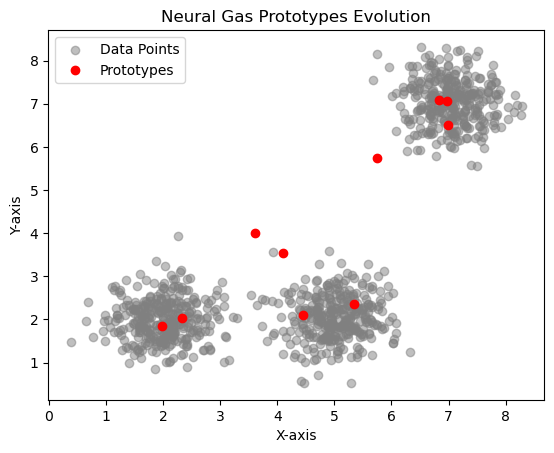

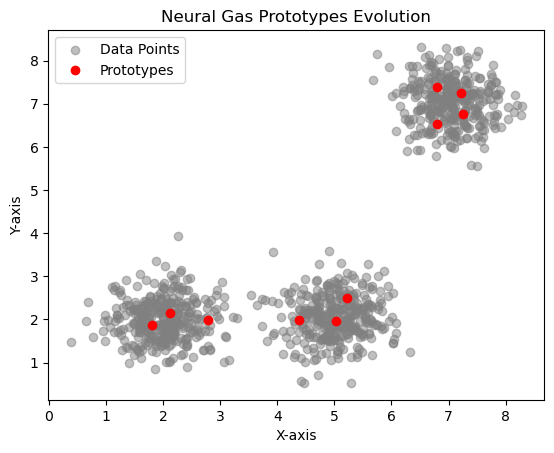

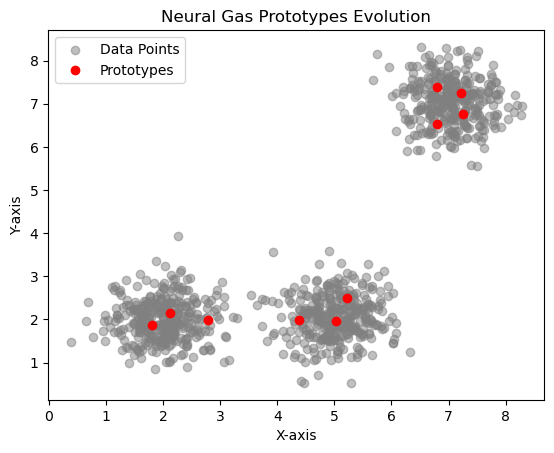

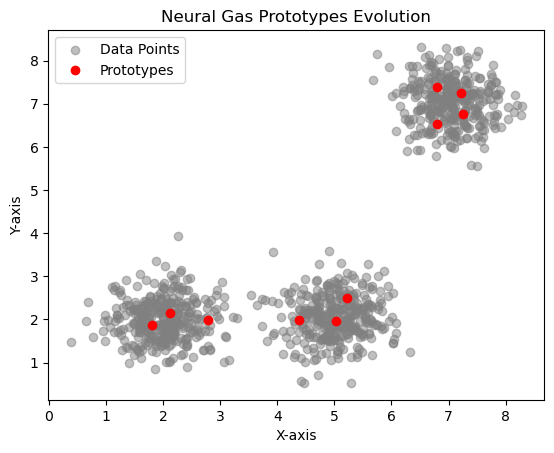

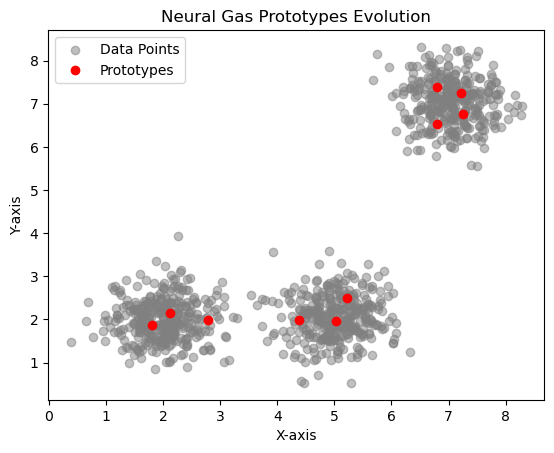

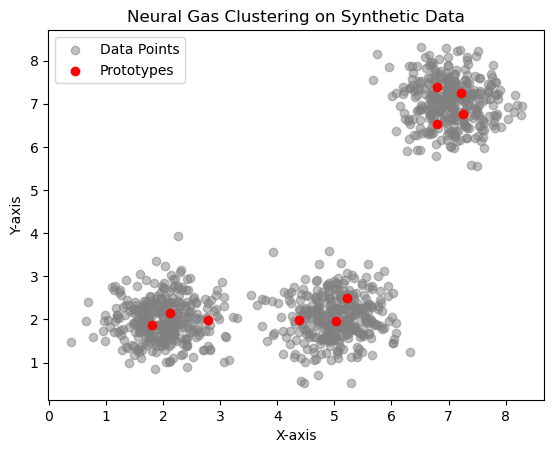

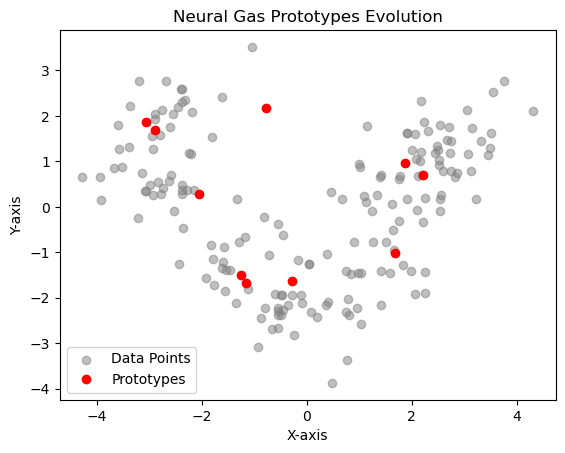

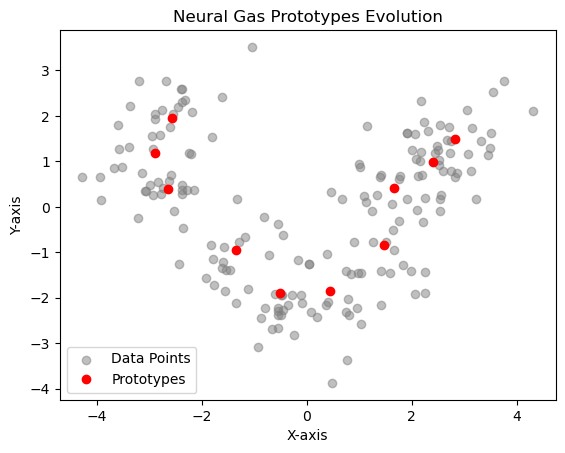

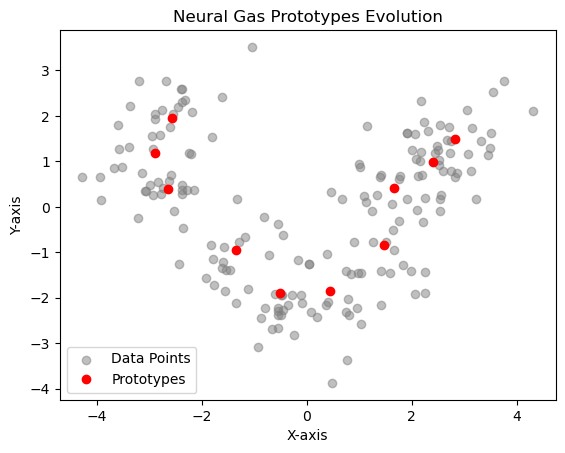

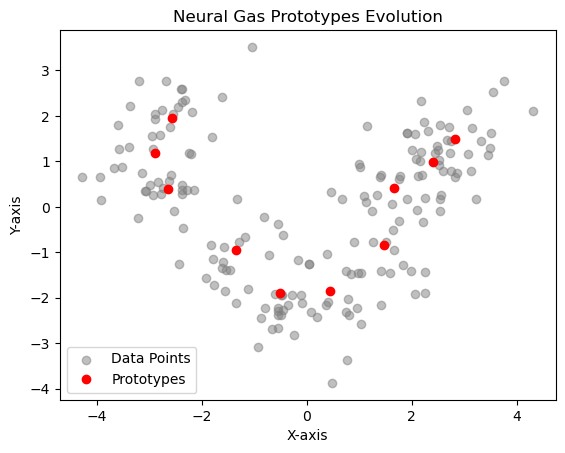

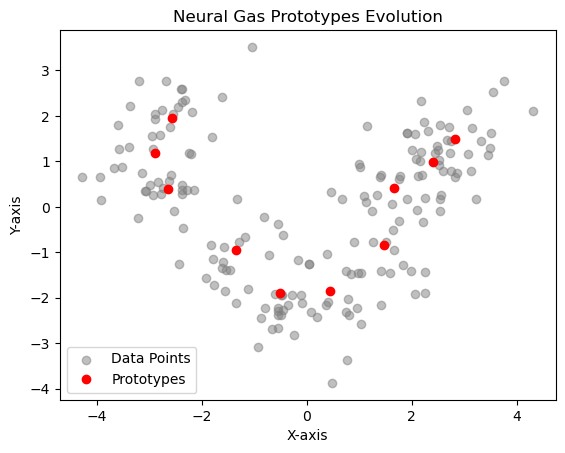

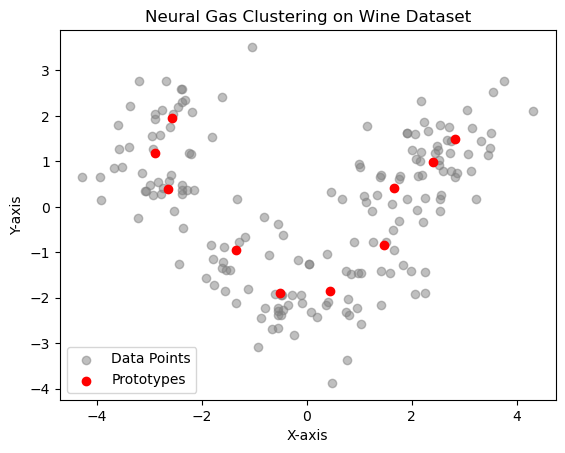

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Generate synthetic dataset (1000 points from three Gaussian distributions)
def generate_synthetic_data():
    np.random.seed(42)
    cluster_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(333, 2))
    cluster_2 = np.random.normal(loc=[7, 7], scale=0.5, size=(333, 2))
    cluster_3 = np.random.normal(loc=[5, 2], scale=0.5, size=(334, 2))
    return np.vstack([cluster_1, cluster_2, cluster_3])


# Load and preprocess Wine dataset
def load_and_preprocess_wine():
    wine = load_wine()
    data = wine.data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data


# Neural Gas Algorithm
def neural_gas(data, n_prototypes, n_iterations, sigma, eta):
    np.random.seed(42)
    prototypes = np.random.uniform(np.min(data), np.max(data), (n_prototypes, data.shape[1]))

    for iteration in range(n_iterations):
        distances = np.linalg.norm(data[:, np.newaxis, :] - prototypes[np.newaxis, :, :], axis=2)
        ranking = np.argsort(distances, axis=1)

        for i in range(n_prototypes):
            rank = np.argsort(np.argsort(distances, axis=1), axis=1)[:, :, np.newaxis]
            update_factor = np.exp(-rank / sigma)
            numerator = np.sum(update_factor[:, i] * data, axis=0)
            denominator = np.sum(update_factor[:, i])
            prototypes[i] = numerator / denominator

        if iteration % 20 == 0:
            fig, ax = plt.subplots()
            ax.scatter(data[:, 0], data[:, 1], c='gray', alpha=0.5, label='Data Points')
            scatter_prototypes, = ax.plot(prototypes[:, 0], prototypes[:, 1], 'ro', label='Prototypes')
            ax.legend()
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('Neural Gas Prototypes Evolution')
            scatter_prototypes.set_data(prototypes[:, 0], prototypes[:, 1])
            plt.pause(0.1)


    return prototypes


# Visualization of prototypes and clusters
def plot_clusters(data, prototypes, title):
    plt.scatter(data[:, 0], data[:, 1], c='gray', alpha=0.5, label='Data Points')
    plt.scatter(prototypes[:, 0], prototypes[:, 1], c='red', label='Prototypes')
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    plt.show()


# Main execution for synthetic dataset
data_synthetic = generate_synthetic_data()
n_prototypes = 10
n_iterations = 100
sigma = 1.0
eta = 0.01

prototypes_synthetic = neural_gas(data_synthetic, n_prototypes, n_iterations, sigma, eta)
plot_clusters(data_synthetic, prototypes_synthetic, "Neural Gas Clustering on Synthetic Data")

# Main execution for Wine dataset
data_wine = load_and_preprocess_wine()

# Reduce to two dimensions for visualization using PCA
pca = PCA(n_components=2)
data_wine_2d = pca.fit_transform(data_wine)

prototypes_wine = neural_gas(data_wine_2d, n_prototypes, n_iterations, sigma, eta)
plot_clusters(data_wine_2d, prototypes_wine, "Neural Gas Clustering on Wine Dataset")
